In [1]:
import numpy as np

from neurodsp.utils import create_times

from neurodsp.plts.spectral import *
from neurodsp.plts.time_series import plot_time_series

from neurodsp import spectral

from numpy import genfromtxt
from numpy import save



from os.path import dirname, join as pjoin
import scipy.io as sio

# Import the FOOOF object
from fooof import FOOOF
from fooof import FOOOFGroup


import pandas as pd


# Import simulation, utility, and plotting tools
from fooof.bands import Bands
from fooof.utils import trim_spectrum
from fooof.analysis import get_band_peak_fm
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectra_shading

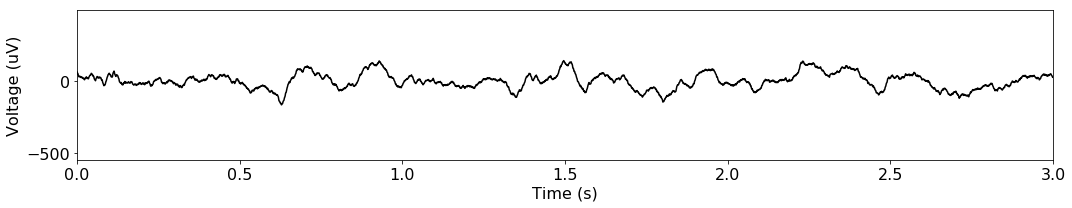

In [2]:
# Load example data signal
fs = 1000
mat_file = '/Volumes/LBCN8T/Stanford/data/neuralData/CARData/CAR/S13_57_TVD/TVD_07/CARiEEGTVD_07_61.mat'
mat_contents = sio.loadmat(mat_file, squeeze_me = True, struct_as_record = False)
data = mat_contents['data']
sig = data.wave


# Plot the loaded signal
times = create_times(len(sig)/fs, fs)
plot_time_series(times, sig, xlim=[0, 3])

In [3]:
len(sig)/1000/60

10.987950000000001

In [4]:
# Mean of spectrogram (Welch)
freq_mean, psd_mean = spectral.compute_spectrum(sig, fs, method='welch', avg_type='mean', nperseg=fs*2)

# Median of spectrogram ("median Welch")
freq_med, psd_med = spectral.compute_spectrum(sig, fs, method='welch', avg_type='median', nperseg=fs*2)

# Median filtered spectrum
#freq_mf, psd_mf = spectral.compute_spectrum(sig, fs, method='medfilt')

In [ ]:
# Plot the power spectra
plot_power_spectra([freq_mean[:200]],
                   [psd_mean[:200]],
                   ['Welch'])

In [ ]:
# Initialize FOOOF object
fm = FOOOF()

# Define frequency range across which to model the spectrum
freq_range = [3, 40]

# Model the power spectrum with FOOOF, and print out a report
fm.report(freq_mean, psd_mean, freq_range)



In [ ]:


all_peaks = []
all_aperiodic = []
all_r_squared = []
all_error = []


all_peaks.append(fm.peak_params_)
all_aperiodic.append(fm.aperiodic_params_)
all_r_squared.append(fm.r_squared_)
all_error.append(fm.error_)


In [ ]:
freq_range

In [ ]:
# Initialize a FOOOFGroup object, specifying some parameters
fg = FOOOFGroup(peak_width_limits=[1.0, 8.0], max_n_peaks=7)

# Fit FOOOF model across the matrix of power spectra
fg.fit(freq_mean, np.array(a), freq_range)


# Create and save out a report summarizing the results across the group of power spectra
fg.save_report('test')


In [ ]:
fg.report()

In [9]:
sbj_rest = pd.read_csv('/Volumes/LBCN8T/Stanford/data/Results/signal_properties/fooof_rest/sbj_rest.csv') 


In [10]:
sbj_rest['sbj_names']

0       S09_07_CM
1      S10_15_KB2
2       S11_22_EG
3       S11_25_DL
4       S11_29_RB
         ...     
75     S19_134_MJ
76     S19_136_AG
77     S19_137_AF
78    S19_139_JRb
79     S19_140_AL
Name: sbj_names, Length: 80, dtype: object

In [16]:
sbj_rest.shape[0]

80

In [36]:
all_peaks = []
all_aperiodic = []
all_r_squared = []
all_error = []
all_spectra = []

dir_data = '/Volumes/LBCN8T/Stanford/data/neuralData/CARData/CAR/'
dir_out = '/Volumes/LBCN8T/Stanford/data/Results/signal_properties/fooof_rest/'

fs = 1000
for isb in range(0,sbj_rest.shape[0]):
    sbj_name = sbj_rest['sbj_names'][isb]
    print('calculating fooof for ' + sbj_name)
    block_name = sbj_rest['block_names'][isb]
    dir_data_sbj = dir_data + sbj_rest['sbj_names'][isb] + '/' + sbj_rest['block_names'][isb] + '/'

    all_peaks = []
    all_aperiodic = []
    all_r_squared = []
    all_error = []
    all_spectra = []
    for i in range(0,sbj_rest['n_elect'][isb]): # 
        print(sbj_name + ' electrode ' + str(i+1).zfill(2))
        mat_file = (dir_data_sbj + 'CARiEEG' + block_name + '_' + str(i+1).zfill(2) + '.mat') 
        mat_contents = sio.loadmat(mat_file, squeeze_me = True, struct_as_record = False)
        data = mat_contents['data']
        sig = data.wave

        # Calculate power spectrum
        freq_mean, psd_mean = spectral.compute_spectrum(sig, fs, method='welch', avg_type='mean', nperseg=fs*2)
        all_spectra.append(psd_mean)


        # Initialize FOOOF object
        fm = FOOOF(verbose = False)
        # Define frequency range across which to model the spectrum
        freq_range = [2, 60]
        # Add the data to the object
        fm.add_data(freq_mean, psd_mean, freq_range)
        # Fit a power spectrum model to the loaded data
        fm.fit()


        fname = (dir_out + sbj_name + '_' + sbj_rest['block_names'][isb] + '_fooof_peak_params_' + str(i+1).zfill(2) + '.csv')       
        np.savetxt(fname, fm.peak_params_, delimiter=',')
        fname = (dir_out + sbj_name + '_' + sbj_rest['block_names'][isb] + '_fooof_aperiodic_params_' + str(i+1).zfill(2) + '.csv')       
        np.savetxt(fname, fm.aperiodic_params_, delimiter=',')
        #fname = (dir_out + sbj_name + '_' + sbj_rest['block_names'][i] + '_fooof_r_squared_' + str(i+1).zfill(2) + '.csv')       
        #np.savetxt(fname, fm.r_squared_, delimiter=',')
        #fname = (dir_out + sbj_name + '_' + sbj_rest['block_names'][i] + '_fooof_error_' + str(i+1).zfill(2) + '.csv')       
        #np.savetxt(fname, fm.error_, delimiter=',')

        all_peaks.append(fm.peak_params_)
        all_aperiodic.append(fm.aperiodic_params_)
        all_r_squared.append(fm.r_squared_)
        all_error.append(fm.error_)

    print(sbj_name + ' fooof group results ') 
    fg = FOOOFGroup(peak_width_limits=[1.0, 8.0], max_n_peaks=8)
    # Fit FOOOF model across the matrix of power spectra
    fg.fit(freq_mean, np.array(all_spectra), freq_range)


calculating fooof for S09_07_CM
S09_07_CM electrode 01
S09_07_CM electrode 02
S09_07_CM electrode 03
S09_07_CM electrode 04
S09_07_CM electrode 05
S09_07_CM electrode 06
S09_07_CM electrode 07
S09_07_CM electrode 08
S09_07_CM electrode 09
S09_07_CM electrode 10
S09_07_CM electrode 11
S09_07_CM electrode 12
S09_07_CM electrode 13
S09_07_CM electrode 14
S09_07_CM electrode 15
S09_07_CM electrode 16
S09_07_CM electrode 17
S09_07_CM electrode 18
S09_07_CM electrode 19
S09_07_CM electrode 20
S09_07_CM electrode 21
S09_07_CM electrode 22
S09_07_CM electrode 23
S09_07_CM electrode 24
S09_07_CM electrode 25
S09_07_CM electrode 26
S09_07_CM electrode 27
S09_07_CM electrode 28
S09_07_CM electrode 29
S09_07_CM electrode 30
S09_07_CM electrode 31
S09_07_CM electrode 32
S09_07_CM electrode 33
S09_07_CM electrode 34
S09_07_CM electrode 35
S09_07_CM electrode 36
S09_07_CM electrode 37
S09_07_CM electrode 38
S09_07_CM electrode 39
S09_07_CM electrode 40
S09_07_CM electrode 41
S09_07_CM electrode 42
S0

S11_29_RB electrode 83
S11_29_RB electrode 84
S11_29_RB electrode 85
S11_29_RB electrode 86
S11_29_RB electrode 87
S11_29_RB electrode 88
S11_29_RB electrode 89
S11_29_RB electrode 90
S11_29_RB electrode 91
S11_29_RB electrode 92
S11_29_RB electrode 93
S11_29_RB electrode 94
S11_29_RB electrode 95
S11_29_RB electrode 96
S11_29_RB electrode 97
S11_29_RB electrode 98
S11_29_RB electrode 99
S11_29_RB electrode 100
S11_29_RB electrode 101
S11_29_RB electrode 102
S11_29_RB electrode 103
S11_29_RB electrode 104
S11_29_RB electrode 105
S11_29_RB electrode 106
S11_29_RB electrode 107
S11_29_RB electrode 108
S11_29_RB electrode 109
S11_29_RB electrode 110
S11_29_RB electrode 111
S11_29_RB electrode 112
S11_29_RB fooof group results 
Running FOOOFGroup across 112 power spectra.
calculating fooof for S11_31_DZb
S11_31_DZb electrode 01
S11_31_DZb electrode 02
S11_31_DZb electrode 03
S11_31_DZb electrode 04
S11_31_DZb electrode 05
S11_31_DZb electrode 06
S11_31_DZb electrode 07
S11_31_DZb electrode

S12_32_JTb electrode 63
S12_32_JTb electrode 64
S12_32_JTb electrode 65
S12_32_JTb electrode 66
S12_32_JTb electrode 67
S12_32_JTb electrode 68
S12_32_JTb electrode 69
S12_32_JTb electrode 70
S12_32_JTb electrode 71
S12_32_JTb electrode 72
S12_32_JTb electrode 73
S12_32_JTb electrode 74
S12_32_JTb electrode 75
S12_32_JTb electrode 76
S12_32_JTb electrode 77
S12_32_JTb electrode 78
S12_32_JTb electrode 79
S12_32_JTb electrode 80
S12_32_JTb electrode 81
S12_32_JTb electrode 82
S12_32_JTb electrode 83
S12_32_JTb electrode 84
S12_32_JTb electrode 85
S12_32_JTb electrode 86
S12_32_JTb electrode 87
S12_32_JTb electrode 88
S12_32_JTb electrode 89
S12_32_JTb electrode 90
S12_32_JTb electrode 91
S12_32_JTb electrode 92
S12_32_JTb electrode 93
S12_32_JTb electrode 94
S12_32_JTb electrode 95
S12_32_JTb electrode 96
S12_32_JTb electrode 97
S12_32_JTb electrode 98
S12_32_JTb electrode 99
S12_32_JTb electrode 100
S12_32_JTb electrode 101
S12_32_JTb electrode 102
S12_32_JTb electrode 103
S12_32_JTb e

S12_37_EJ electrode 43
S12_37_EJ electrode 44
S12_37_EJ electrode 45
S12_37_EJ electrode 46
S12_37_EJ electrode 47
S12_37_EJ electrode 48
S12_37_EJ electrode 49
S12_37_EJ electrode 50
S12_37_EJ electrode 51
S12_37_EJ electrode 52
S12_37_EJ electrode 53
S12_37_EJ electrode 54
S12_37_EJ electrode 55
S12_37_EJ electrode 56
S12_37_EJ electrode 57
S12_37_EJ electrode 58
S12_37_EJ electrode 59
S12_37_EJ electrode 60
S12_37_EJ electrode 61
S12_37_EJ electrode 62
S12_37_EJ electrode 63
S12_37_EJ electrode 64
S12_37_EJ electrode 65
S12_37_EJ electrode 66
S12_37_EJ electrode 67
S12_37_EJ electrode 68
S12_37_EJ electrode 69
S12_37_EJ electrode 70
S12_37_EJ electrode 71
S12_37_EJ electrode 72
S12_37_EJ electrode 73
S12_37_EJ electrode 74
S12_37_EJ electrode 75
S12_37_EJ electrode 76
S12_37_EJ electrode 77
S12_37_EJ electrode 78
S12_37_EJ electrode 79
S12_37_EJ electrode 80
S12_37_EJ electrode 81
S12_37_EJ electrode 82
S12_37_EJ electrode 83
S12_37_EJ electrode 84
S12_37_EJ electrode 85
S12_37_EJ e

S12_42_NC electrode 19
S12_42_NC electrode 20
S12_42_NC electrode 21
S12_42_NC electrode 22
S12_42_NC electrode 23
S12_42_NC electrode 24
S12_42_NC electrode 25
S12_42_NC electrode 26
S12_42_NC electrode 27
S12_42_NC electrode 28
S12_42_NC electrode 29
S12_42_NC electrode 30
S12_42_NC electrode 31
S12_42_NC electrode 32
S12_42_NC electrode 33
S12_42_NC electrode 34
S12_42_NC electrode 35
S12_42_NC electrode 36
S12_42_NC electrode 37
S12_42_NC electrode 38
S12_42_NC electrode 39
S12_42_NC electrode 40
S12_42_NC electrode 41
S12_42_NC electrode 42
S12_42_NC electrode 43
S12_42_NC electrode 44
S12_42_NC electrode 45
S12_42_NC electrode 46
S12_42_NC electrode 47
S12_42_NC electrode 48
S12_42_NC electrode 49
S12_42_NC electrode 50
S12_42_NC electrode 51
S12_42_NC electrode 52
S12_42_NC electrode 53
S12_42_NC electrode 54
S12_42_NC electrode 55
S12_42_NC electrode 56
S12_42_NC electrode 57
S12_42_NC electrode 58
S12_42_NC electrode 59
S12_42_NC electrode 60
S12_42_NC electrode 61
S12_42_NC e

S13_47_JT2 electrode 25
S13_47_JT2 electrode 26
S13_47_JT2 electrode 27
S13_47_JT2 electrode 28
S13_47_JT2 electrode 29
S13_47_JT2 electrode 30
S13_47_JT2 electrode 31
S13_47_JT2 electrode 32
S13_47_JT2 electrode 33
S13_47_JT2 electrode 34
S13_47_JT2 electrode 35
S13_47_JT2 electrode 36
S13_47_JT2 electrode 37
S13_47_JT2 electrode 38
S13_47_JT2 electrode 39
S13_47_JT2 electrode 40
S13_47_JT2 electrode 41
S13_47_JT2 electrode 42
S13_47_JT2 electrode 43
S13_47_JT2 electrode 44
S13_47_JT2 electrode 45
S13_47_JT2 electrode 46
S13_47_JT2 electrode 47
S13_47_JT2 electrode 48
S13_47_JT2 electrode 49
S13_47_JT2 electrode 50
S13_47_JT2 electrode 51
S13_47_JT2 electrode 52
S13_47_JT2 electrode 53
S13_47_JT2 electrode 54
S13_47_JT2 electrode 55
S13_47_JT2 electrode 56
S13_47_JT2 electrode 57
S13_47_JT2 electrode 58
S13_47_JT2 electrode 59
S13_47_JT2 electrode 60
S13_47_JT2 electrode 61
S13_47_JT2 electrode 62
S13_47_JT2 electrode 63
S13_47_JT2 electrode 64
S13_47_JT2 electrode 65
S13_47_JT2 elect

S13_53_KS2 electrode 101
S13_53_KS2 electrode 102
S13_53_KS2 electrode 103
S13_53_KS2 electrode 104
S13_53_KS2 electrode 105
S13_53_KS2 electrode 106
S13_53_KS2 electrode 107
S13_53_KS2 electrode 108
S13_53_KS2 electrode 109
S13_53_KS2 electrode 110
S13_53_KS2 electrode 111
S13_53_KS2 electrode 112
S13_53_KS2 electrode 113
S13_53_KS2 electrode 114
S13_53_KS2 electrode 115
S13_53_KS2 electrode 116
S13_53_KS2 electrode 117
S13_53_KS2 electrode 118
S13_53_KS2 electrode 119
S13_53_KS2 electrode 120
S13_53_KS2 electrode 121
S13_53_KS2 electrode 122
S13_53_KS2 electrode 123
S13_53_KS2 electrode 124
S13_53_KS2 electrode 125
S13_53_KS2 electrode 126
S13_53_KS2 electrode 127
S13_53_KS2 electrode 128
S13_53_KS2 fooof group results 
Running FOOOFGroup across 128 power spectra.
calculating fooof for S13_55_JJC
S13_55_JJC electrode 01
S13_55_JJC electrode 02
S13_55_JJC electrode 03
S13_55_JJC electrode 04
S13_55_JJC electrode 05
S13_55_JJC electrode 06
S13_55_JJC electrode 07
S13_55_JJC electrode 0

S13_57_TVD electrode 43
S13_57_TVD electrode 44
S13_57_TVD electrode 45
S13_57_TVD electrode 46
S13_57_TVD electrode 47
S13_57_TVD electrode 48
S13_57_TVD electrode 49
S13_57_TVD electrode 50
S13_57_TVD electrode 51
S13_57_TVD electrode 52
S13_57_TVD electrode 53
S13_57_TVD electrode 54
S13_57_TVD electrode 55
S13_57_TVD electrode 56
S13_57_TVD electrode 57
S13_57_TVD electrode 58
S13_57_TVD electrode 59
S13_57_TVD electrode 60
S13_57_TVD electrode 61
S13_57_TVD electrode 62
S13_57_TVD electrode 63
S13_57_TVD electrode 64
S13_57_TVD electrode 65
S13_57_TVD electrode 66
S13_57_TVD electrode 67
S13_57_TVD electrode 68
S13_57_TVD electrode 69
S13_57_TVD electrode 70
S13_57_TVD electrode 71
S13_57_TVD electrode 72
S13_57_TVD electrode 73
S13_57_TVD electrode 74
S13_57_TVD electrode 75
S13_57_TVD electrode 76
S13_57_TVD electrode 77
S13_57_TVD electrode 78
S13_57_TVD electrode 79
S13_57_TVD electrode 80
S13_57_TVD electrode 81
S13_57_TVD electrode 82
S13_57_TVD electrode 83
S13_57_TVD elect

S14_62_JW electrode 14
S14_62_JW electrode 15
S14_62_JW electrode 16
S14_62_JW electrode 17
S14_62_JW electrode 18
S14_62_JW electrode 19
S14_62_JW electrode 20
S14_62_JW electrode 21
S14_62_JW electrode 22
S14_62_JW electrode 23
S14_62_JW electrode 24
S14_62_JW electrode 25
S14_62_JW electrode 26
S14_62_JW electrode 27
S14_62_JW electrode 28
S14_62_JW electrode 29
S14_62_JW electrode 30
S14_62_JW electrode 31
S14_62_JW electrode 32
S14_62_JW electrode 33
S14_62_JW electrode 34
S14_62_JW electrode 35
S14_62_JW electrode 36
S14_62_JW electrode 37
S14_62_JW electrode 38
S14_62_JW electrode 39
S14_62_JW electrode 40
S14_62_JW electrode 41
S14_62_JW electrode 42
S14_62_JW electrode 43
S14_62_JW electrode 44
S14_62_JW electrode 45
S14_62_JW electrode 46
S14_62_JW electrode 47
S14_62_JW electrode 48
S14_62_JW electrode 49
S14_62_JW electrode 50
S14_62_JW electrode 51
S14_62_JW electrode 52
S14_62_JW electrode 53
S14_62_JW electrode 54
S14_62_JW electrode 55
S14_62_JW electrode 56
S14_62_JW e

S14_66_CZ electrode 115
S14_66_CZ electrode 116
S14_66_CZ fooof group results 
Running FOOOFGroup across 116 power spectra.
calculating fooof for S14_67_RH
S14_67_RH electrode 01
S14_67_RH electrode 02
S14_67_RH electrode 03
S14_67_RH electrode 04
S14_67_RH electrode 05
S14_67_RH electrode 06
S14_67_RH electrode 07
S14_67_RH electrode 08
S14_67_RH electrode 09
S14_67_RH electrode 10
S14_67_RH electrode 11
S14_67_RH electrode 12
S14_67_RH electrode 13
S14_67_RH electrode 14
S14_67_RH electrode 15
S14_67_RH electrode 16
S14_67_RH electrode 17
S14_67_RH electrode 18
S14_67_RH electrode 19
S14_67_RH electrode 20
S14_67_RH electrode 21
S14_67_RH electrode 22
S14_67_RH electrode 23
S14_67_RH electrode 24
S14_67_RH electrode 25
S14_67_RH electrode 26
S14_67_RH electrode 27
S14_67_RH electrode 28
S14_67_RH electrode 29
S14_67_RH electrode 30
S14_67_RH electrode 31
S14_67_RH electrode 32
S14_67_RH electrode 33
S14_67_RH electrode 34
S14_67_RH electrode 35
S14_67_RH electrode 36
S14_67_RH electr

S14_75_TB electrode 07
S14_75_TB electrode 08
S14_75_TB electrode 09
S14_75_TB electrode 10
S14_75_TB electrode 11
S14_75_TB electrode 12
S14_75_TB electrode 13
S14_75_TB electrode 14
S14_75_TB electrode 15
S14_75_TB electrode 16
S14_75_TB electrode 17
S14_75_TB electrode 18
S14_75_TB electrode 19
S14_75_TB electrode 20
S14_75_TB electrode 21
S14_75_TB electrode 22
S14_75_TB electrode 23
S14_75_TB electrode 24
S14_75_TB electrode 25
S14_75_TB electrode 26
S14_75_TB electrode 27
S14_75_TB electrode 28
S14_75_TB electrode 29
S14_75_TB electrode 30
S14_75_TB electrode 31
S14_75_TB electrode 32
S14_75_TB electrode 33
S14_75_TB electrode 34
S14_75_TB electrode 35
S14_75_TB electrode 36
S14_75_TB electrode 37
S14_75_TB electrode 38
S14_75_TB electrode 39
S14_75_TB electrode 40
S14_75_TB electrode 41
S14_75_TB electrode 42
S14_75_TB electrode 43
S14_75_TB electrode 44
S14_75_TB electrode 45
S14_75_TB electrode 46
S14_75_TB electrode 47
S14_75_TB electrode 48
S14_75_TB electrode 49
S14_75_TB e

S14_78_RSa electrode 92
S14_78_RSa electrode 93
S14_78_RSa electrode 94
S14_78_RSa electrode 95
S14_78_RSa electrode 96
S14_78_RSa electrode 97
S14_78_RSa electrode 98
S14_78_RSa electrode 99
S14_78_RSa electrode 100
S14_78_RSa electrode 101
S14_78_RSa electrode 102
S14_78_RSa electrode 103
S14_78_RSa electrode 104
S14_78_RSa electrode 105
S14_78_RSa electrode 106
S14_78_RSa electrode 107
S14_78_RSa electrode 108
S14_78_RSa electrode 109
S14_78_RSa electrode 110
S14_78_RSa electrode 111
S14_78_RSa electrode 112
S14_78_RSa electrode 113
S14_78_RSa electrode 114
S14_78_RSa electrode 115
S14_78_RSa electrode 116
S14_78_RSa electrode 117
S14_78_RSa electrode 118
S14_78_RSa electrode 119
S14_78_RSa electrode 120
S14_78_RSa electrode 121
S14_78_RSa electrode 122
S14_78_RSa electrode 123
S14_78_RSa electrode 124
S14_78_RSa electrode 125
S14_78_RSa electrode 126
S14_78_RSa electrode 127
S14_78_RSa electrode 128
S14_78_RSa electrode 129
S14_78_RSa electrode 130
S14_78_RSa electrode 131
S14_78_R

S15_81_RM electrode 72
S15_81_RM electrode 73
S15_81_RM electrode 74
S15_81_RM electrode 75
S15_81_RM electrode 76
S15_81_RM electrode 77
S15_81_RM electrode 78
S15_81_RM electrode 79
S15_81_RM electrode 80
S15_81_RM electrode 81
S15_81_RM electrode 82
S15_81_RM electrode 83
S15_81_RM electrode 84
S15_81_RM electrode 85
S15_81_RM electrode 86
S15_81_RM electrode 87
S15_81_RM electrode 88
S15_81_RM electrode 89
S15_81_RM electrode 90
S15_81_RM electrode 91
S15_81_RM electrode 92
S15_81_RM electrode 93
S15_81_RM electrode 94
S15_81_RM electrode 95
S15_81_RM electrode 96
S15_81_RM electrode 97
S15_81_RM electrode 98
S15_81_RM electrode 99
S15_81_RM electrode 100
S15_81_RM electrode 101
S15_81_RM electrode 102
S15_81_RM electrode 103
S15_81_RM electrode 104
S15_81_RM electrode 105
S15_81_RM electrode 106
S15_81_RM electrode 107
S15_81_RM electrode 108
S15_81_RM electrode 109
S15_81_RM electrode 110
S15_81_RM electrode 111
S15_81_RM electrode 112
S15_81_RM electrode 113
S15_81_RM electrode 

S15_83_RR electrode 126
S15_83_RR electrode 127
S15_83_RR electrode 128
S15_83_RR fooof group results 
Running FOOOFGroup across 128 power spectra.
calculating fooof for S15_84_KG
S15_84_KG electrode 01
S15_84_KG electrode 02
S15_84_KG electrode 03
S15_84_KG electrode 04
S15_84_KG electrode 05
S15_84_KG electrode 06
S15_84_KG electrode 07
S15_84_KG electrode 08
S15_84_KG electrode 09
S15_84_KG electrode 10
S15_84_KG electrode 11
S15_84_KG electrode 12
S15_84_KG electrode 13
S15_84_KG electrode 14
S15_84_KG electrode 15
S15_84_KG electrode 16
S15_84_KG electrode 17
S15_84_KG electrode 18
S15_84_KG electrode 19
S15_84_KG electrode 20
S15_84_KG electrode 21
S15_84_KG electrode 22
S15_84_KG electrode 23
S15_84_KG electrode 24
S15_84_KG electrode 25
S15_84_KG electrode 26
S15_84_KG electrode 27
S15_84_KG electrode 28
S15_84_KG electrode 29
S15_84_KG electrode 30
S15_84_KG electrode 31
S15_84_KG electrode 32
S15_84_KG electrode 33
S15_84_KG electrode 34
S15_84_KG electrode 35
S15_84_KG elect

S15_89_JQb electrode 44
S15_89_JQb electrode 45
S15_89_JQb electrode 46
S15_89_JQb electrode 47
S15_89_JQb electrode 48
S15_89_JQb electrode 49
S15_89_JQb electrode 50
S15_89_JQb electrode 51
S15_89_JQb electrode 52
S15_89_JQb electrode 53
S15_89_JQb electrode 54
S15_89_JQb electrode 55
S15_89_JQb electrode 56
S15_89_JQb electrode 57
S15_89_JQb electrode 58
S15_89_JQb electrode 59
S15_89_JQb electrode 60
S15_89_JQb electrode 61
S15_89_JQb electrode 62
S15_89_JQb electrode 63
S15_89_JQb electrode 64
S15_89_JQb electrode 65
S15_89_JQb electrode 66
S15_89_JQb electrode 67
S15_89_JQb electrode 68
S15_89_JQb electrode 69
S15_89_JQb electrode 70
S15_89_JQb electrode 71
S15_89_JQb electrode 72
S15_89_JQb electrode 73
S15_89_JQb electrode 74
S15_89_JQb electrode 75
S15_89_JQb electrode 76
S15_89_JQb electrode 77
S15_89_JQb electrode 78
S15_89_JQb electrode 79
S15_89_JQb electrode 80
S15_89_JQb electrode 81
S15_89_JQb electrode 82
S15_89_JQb electrode 83
S15_89_JQb electrode 84
S15_89_JQb elect

S15_92_MR electrode 50
S15_92_MR electrode 51
S15_92_MR electrode 52
S15_92_MR electrode 53
S15_92_MR electrode 54
S15_92_MR electrode 55
S15_92_MR electrode 56
S15_92_MR electrode 57
S15_92_MR electrode 58
S15_92_MR electrode 59
S15_92_MR electrode 60
S15_92_MR electrode 61
S15_92_MR electrode 62
S15_92_MR electrode 63
S15_92_MR electrode 64
S15_92_MR electrode 65
S15_92_MR electrode 66
S15_92_MR electrode 67
S15_92_MR electrode 68
S15_92_MR electrode 69
S15_92_MR electrode 70
S15_92_MR electrode 71
S15_92_MR electrode 72
S15_92_MR electrode 73
S15_92_MR electrode 74
S15_92_MR electrode 75
S15_92_MR electrode 76
S15_92_MR electrode 77
S15_92_MR electrode 78
S15_92_MR electrode 79
S15_92_MR electrode 80
S15_92_MR electrode 81
S15_92_MR electrode 82
S15_92_MR electrode 83
S15_92_MR electrode 84
S15_92_MR electrode 85
S15_92_MR electrode 86
S15_92_MR electrode 87
S15_92_MR electrode 88
S15_92_MR electrode 89
S15_92_MR electrode 90
S15_92_MR electrode 91
S15_92_MR electrode 92
S15_92_MR e

S16_95_JOB electrode 03
S16_95_JOB electrode 04
S16_95_JOB electrode 05
S16_95_JOB electrode 06
S16_95_JOB electrode 07
S16_95_JOB electrode 08
S16_95_JOB electrode 09
S16_95_JOB electrode 10
S16_95_JOB electrode 11
S16_95_JOB electrode 12
S16_95_JOB electrode 13
S16_95_JOB electrode 14
S16_95_JOB electrode 15
S16_95_JOB electrode 16
S16_95_JOB electrode 17
S16_95_JOB electrode 18
S16_95_JOB electrode 19
S16_95_JOB electrode 20
S16_95_JOB electrode 21
S16_95_JOB electrode 22
S16_95_JOB electrode 23
S16_95_JOB electrode 24
S16_95_JOB electrode 25
S16_95_JOB electrode 26
S16_95_JOB electrode 27
S16_95_JOB electrode 28
S16_95_JOB electrode 29
S16_95_JOB electrode 30
S16_95_JOB electrode 31
S16_95_JOB electrode 32
S16_95_JOB electrode 33
S16_95_JOB electrode 34
S16_95_JOB electrode 35
S16_95_JOB electrode 36
S16_95_JOB electrode 37
S16_95_JOB electrode 38
S16_95_JOB electrode 39
S16_95_JOB electrode 40
S16_95_JOB electrode 41
S16_95_JOB electrode 42
S16_95_JOB electrode 43
S16_95_JOB elect

S16_99_CJ electrode 60
S16_99_CJ electrode 61
S16_99_CJ electrode 62
S16_99_CJ electrode 63
S16_99_CJ electrode 64
S16_99_CJ electrode 65
S16_99_CJ electrode 66
S16_99_CJ electrode 67
S16_99_CJ electrode 68
S16_99_CJ electrode 69
S16_99_CJ electrode 70
S16_99_CJ electrode 71
S16_99_CJ electrode 72
S16_99_CJ electrode 73
S16_99_CJ electrode 74
S16_99_CJ electrode 75
S16_99_CJ electrode 76
S16_99_CJ electrode 77
S16_99_CJ electrode 78
S16_99_CJ electrode 79
S16_99_CJ electrode 80
S16_99_CJ fooof group results 
Running FOOOFGroup across 80 power spectra.
calculating fooof for S17_104_SW
S17_104_SW electrode 01
S17_104_SW electrode 02
S17_104_SW electrode 03
S17_104_SW electrode 04
S17_104_SW electrode 05
S17_104_SW electrode 06
S17_104_SW electrode 07
S17_104_SW electrode 08
S17_104_SW electrode 09
S17_104_SW electrode 10
S17_104_SW electrode 11
S17_104_SW electrode 12
S17_104_SW electrode 13
S17_104_SW electrode 14
S17_104_SW electrode 15
S17_104_SW electrode 16
S17_104_SW electrode 17
S

S17_106_SD electrode 55
S17_106_SD electrode 56
S17_106_SD electrode 57
S17_106_SD electrode 58
S17_106_SD electrode 59
S17_106_SD electrode 60
S17_106_SD electrode 61
S17_106_SD electrode 62
S17_106_SD electrode 63
S17_106_SD electrode 64
S17_106_SD electrode 65
S17_106_SD electrode 66
S17_106_SD electrode 67
S17_106_SD electrode 68
S17_106_SD electrode 69
S17_106_SD electrode 70
S17_106_SD electrode 71
S17_106_SD electrode 72
S17_106_SD electrode 73
S17_106_SD electrode 74
S17_106_SD electrode 75
S17_106_SD electrode 76
S17_106_SD electrode 77
S17_106_SD electrode 78
S17_106_SD electrode 79
S17_106_SD electrode 80
S17_106_SD electrode 81
S17_106_SD electrode 82
S17_106_SD electrode 83
S17_106_SD electrode 84
S17_106_SD fooof group results 
Running FOOOFGroup across 84 power spectra.
calculating fooof for S17_107_PR
S17_107_PR electrode 01
S17_107_PR electrode 02
S17_107_PR electrode 03
S17_107_PR electrode 04
S17_107_PR electrode 05
S17_107_PR electrode 06
S17_107_PR electrode 07
S17

S17_109_NM electrode 121
S17_109_NM electrode 122
S17_109_NM electrode 123
S17_109_NM electrode 124
S17_109_NM electrode 125
S17_109_NM electrode 126
S17_109_NM electrode 127
S17_109_NM electrode 128
S17_109_NM electrode 129
S17_109_NM electrode 130
S17_109_NM electrode 131
S17_109_NM electrode 132
S17_109_NM electrode 133
S17_109_NM electrode 134
S17_109_NM electrode 135
S17_109_NM electrode 136
S17_109_NM electrode 137
S17_109_NM electrode 138
S17_109_NM electrode 139
S17_109_NM electrode 140
S17_109_NM electrode 141
S17_109_NM electrode 142
S17_109_NM electrode 143
S17_109_NM electrode 144
S17_109_NM electrode 145
S17_109_NM electrode 146
S17_109_NM electrode 147
S17_109_NM electrode 148
S17_109_NM electrode 149
S17_109_NM electrode 150
S17_109_NM fooof group results 
Running FOOOFGroup across 150 power spectra.
calculating fooof for S17_110_SC
S17_110_SC electrode 01
S17_110_SC electrode 02
S17_110_SC electrode 03
S17_110_SC electrode 04
S17_110_SC electrode 05
S17_110_SC electrode

S17_114_EB electrode 12
S17_114_EB electrode 13
S17_114_EB electrode 14
S17_114_EB electrode 15
S17_114_EB electrode 16
S17_114_EB electrode 17
S17_114_EB electrode 18
S17_114_EB electrode 19
S17_114_EB electrode 20
S17_114_EB electrode 21
S17_114_EB electrode 22
S17_114_EB electrode 23
S17_114_EB electrode 24
S17_114_EB electrode 25
S17_114_EB electrode 26
S17_114_EB electrode 27
S17_114_EB electrode 28
S17_114_EB electrode 29
S17_114_EB electrode 30
S17_114_EB electrode 31
S17_114_EB electrode 32
S17_114_EB electrode 33
S17_114_EB electrode 34
S17_114_EB electrode 35
S17_114_EB electrode 36
S17_114_EB electrode 37
S17_114_EB electrode 38
S17_114_EB electrode 39
S17_114_EB electrode 40
S17_114_EB electrode 41
S17_114_EB electrode 42
S17_114_EB electrode 43
S17_114_EB electrode 44
S17_114_EB electrode 45
S17_114_EB electrode 46
S17_114_EB electrode 47
S17_114_EB electrode 48
S17_114_EB electrode 49
S17_114_EB electrode 50
S17_114_EB electrode 51
S17_114_EB electrode 52
S17_114_EB elect

S17_116_AA electrode 120
S17_116_AA electrode 121
S17_116_AA electrode 122
S17_116_AA electrode 123
S17_116_AA electrode 124
S17_116_AA electrode 125
S17_116_AA electrode 126
S17_116_AA electrode 127
S17_116_AA electrode 128
S17_116_AA fooof group results 
Running FOOOFGroup across 128 power spectra.
calculating fooof for S17_69_RTb
S17_69_RTb electrode 01
S17_69_RTb electrode 02
S17_69_RTb electrode 03
S17_69_RTb electrode 04
S17_69_RTb electrode 05
S17_69_RTb electrode 06
S17_69_RTb electrode 07
S17_69_RTb electrode 08
S17_69_RTb electrode 09
S17_69_RTb electrode 10
S17_69_RTb electrode 11
S17_69_RTb electrode 12
S17_69_RTb electrode 13
S17_69_RTb electrode 14
S17_69_RTb electrode 15
S17_69_RTb electrode 16
S17_69_RTb electrode 17
S17_69_RTb electrode 18
S17_69_RTb electrode 19
S17_69_RTb electrode 20
S17_69_RTb electrode 21
S17_69_RTb electrode 22
S17_69_RTb electrode 23
S17_69_RTb electrode 24
S17_69_RTb electrode 25
S17_69_RTb electrode 26
S17_69_RTb electrode 27
S17_69_RTb electr

S18_120_EGa electrode 108
S18_120_EGa electrode 109
S18_120_EGa electrode 110
S18_120_EGa electrode 111
S18_120_EGa electrode 112
S18_120_EGa electrode 113
S18_120_EGa electrode 114
S18_120_EGa electrode 115
S18_120_EGa electrode 116
S18_120_EGa electrode 117
S18_120_EGa electrode 118
S18_120_EGa electrode 119
S18_120_EGa electrode 120
S18_120_EGa electrode 121
S18_120_EGa electrode 122
S18_120_EGa electrode 123
S18_120_EGa electrode 124
S18_120_EGa electrode 125
S18_120_EGa electrode 126
S18_120_EGa electrode 127
S18_120_EGa electrode 128
S18_120_EGa electrode 129
S18_120_EGa electrode 130
S18_120_EGa electrode 131
S18_120_EGa electrode 132
S18_120_EGa fooof group results 
Running FOOOFGroup across 132 power spectra.
calculating fooof for S18_120_EGb
S18_120_EGb electrode 01
S18_120_EGb electrode 02
S18_120_EGb electrode 03
S18_120_EGb electrode 04
S18_120_EGb electrode 05
S18_120_EGb electrode 06
S18_120_EGb electrode 07
S18_120_EGb electrode 08
S18_120_EGb electrode 09
S18_120_EGb e

S18_123_KJ electrode 190
S18_123_KJ electrode 191
S18_123_KJ electrode 192
S18_123_KJ electrode 193
S18_123_KJ electrode 194
S18_123_KJ electrode 195
S18_123_KJ electrode 196
S18_123_KJ electrode 197
S18_123_KJ electrode 198
S18_123_KJ electrode 199
S18_123_KJ electrode 200
S18_123_KJ electrode 201
S18_123_KJ electrode 202
S18_123_KJ electrode 203
S18_123_KJ electrode 204
S18_123_KJ electrode 205
S18_123_KJ electrode 206
S18_123_KJ electrode 207
S18_123_KJ electrode 208
S18_123_KJ electrode 209
S18_123_KJ electrode 210
S18_123_KJ fooof group results 
Running FOOOFGroup across 210 power spectra.
calculating fooof for S18_124_JR2
S18_124_JR2 electrode 01
S18_124_JR2 electrode 02
S18_124_JR2 electrode 03
S18_124_JR2 electrode 04
S18_124_JR2 electrode 05
S18_124_JR2 electrode 06
S18_124_JR2 electrode 07
S18_124_JR2 electrode 08
S18_124_JR2 electrode 09
S18_124_JR2 electrode 10
S18_124_JR2 electrode 11
S18_124_JR2 electrode 12
S18_124_JR2 electrode 13
S18_124_JR2 electrode 14
S18_124_JR2 el

S18_126_DF electrode 51
S18_126_DF electrode 52
S18_126_DF electrode 53
S18_126_DF electrode 54
S18_126_DF electrode 55
S18_126_DF electrode 56
S18_126_DF electrode 57
S18_126_DF electrode 58
S18_126_DF electrode 59
S18_126_DF electrode 60
S18_126_DF electrode 61
S18_126_DF electrode 62
S18_126_DF electrode 63
S18_126_DF electrode 64
S18_126_DF electrode 65
S18_126_DF electrode 66
S18_126_DF electrode 67
S18_126_DF electrode 68
S18_126_DF electrode 69
S18_126_DF electrode 70
S18_126_DF electrode 71
S18_126_DF electrode 72
S18_126_DF electrode 73
S18_126_DF electrode 74
S18_126_DF electrode 75
S18_126_DF electrode 76
S18_126_DF electrode 77
S18_126_DF electrode 78
S18_126_DF electrode 79
S18_126_DF electrode 80
S18_126_DF electrode 81
S18_126_DF electrode 82
S18_126_DF electrode 83
S18_126_DF electrode 84
S18_126_DF electrode 85
S18_126_DF electrode 86
S18_126_DF electrode 87
S18_126_DF electrode 88
S18_126_DF electrode 89
S18_126_DF electrode 90
S18_126_DF electrode 91
S18_126_DF elect

S18_130_RH electrode 85
S18_130_RH electrode 86
S18_130_RH electrode 87
S18_130_RH electrode 88
S18_130_RH electrode 89
S18_130_RH electrode 90
S18_130_RH electrode 91
S18_130_RH electrode 92
S18_130_RH electrode 93
S18_130_RH electrode 94
S18_130_RH electrode 95
S18_130_RH electrode 96
S18_130_RH electrode 97
S18_130_RH electrode 98
S18_130_RH electrode 99
S18_130_RH electrode 100
S18_130_RH electrode 101
S18_130_RH fooof group results 
Running FOOOFGroup across 101 power spectra.
calculating fooof for S18_131_CB
S18_131_CB electrode 01
S18_131_CB electrode 02
S18_131_CB electrode 03
S18_131_CB electrode 04
S18_131_CB electrode 05
S18_131_CB electrode 06
S18_131_CB electrode 07
S18_131_CB electrode 08
S18_131_CB electrode 09
S18_131_CB electrode 10
S18_131_CB electrode 11
S18_131_CB electrode 12
S18_131_CB electrode 13
S18_131_CB electrode 14
S18_131_CB electrode 15
S18_131_CB electrode 16
S18_131_CB electrode 17
S18_131_CB electrode 18
S18_131_CB electrode 19
S18_131_CB electrode 20


S19_134_MJ electrode 32
S19_134_MJ electrode 33
S19_134_MJ electrode 34
S19_134_MJ electrode 35
S19_134_MJ electrode 36
S19_134_MJ electrode 37
S19_134_MJ electrode 38
S19_134_MJ electrode 39
S19_134_MJ electrode 40
S19_134_MJ electrode 41
S19_134_MJ electrode 42
S19_134_MJ electrode 43
S19_134_MJ electrode 44
S19_134_MJ electrode 45
S19_134_MJ electrode 46
S19_134_MJ electrode 47
S19_134_MJ electrode 48
S19_134_MJ electrode 49
S19_134_MJ electrode 50
S19_134_MJ electrode 51
S19_134_MJ electrode 52
S19_134_MJ electrode 53
S19_134_MJ electrode 54
S19_134_MJ electrode 55
S19_134_MJ electrode 56
S19_134_MJ electrode 57
S19_134_MJ electrode 58
S19_134_MJ electrode 59
S19_134_MJ electrode 60
S19_134_MJ electrode 61
S19_134_MJ electrode 62
S19_134_MJ electrode 63
S19_134_MJ electrode 64
S19_134_MJ electrode 65
S19_134_MJ electrode 66
S19_134_MJ electrode 67
S19_134_MJ electrode 68
S19_134_MJ electrode 69
S19_134_MJ electrode 70
S19_134_MJ electrode 71
S19_134_MJ electrode 72
S19_134_MJ elect

S19_137_AF electrode 110
S19_137_AF electrode 111
S19_137_AF electrode 112
S19_137_AF electrode 113
S19_137_AF electrode 114
S19_137_AF electrode 115
S19_137_AF electrode 116
S19_137_AF electrode 117
S19_137_AF electrode 118
S19_137_AF electrode 119
S19_137_AF electrode 120
S19_137_AF electrode 121
S19_137_AF electrode 122
S19_137_AF electrode 123
S19_137_AF electrode 124
S19_137_AF electrode 125
S19_137_AF electrode 126
S19_137_AF electrode 127
S19_137_AF electrode 128
S19_137_AF electrode 129
S19_137_AF electrode 130
S19_137_AF electrode 131
S19_137_AF electrode 132
S19_137_AF electrode 133
S19_137_AF electrode 134
S19_137_AF electrode 135
S19_137_AF electrode 136
S19_137_AF electrode 137
S19_137_AF electrode 138
S19_137_AF electrode 139
S19_137_AF electrode 140
S19_137_AF electrode 141
S19_137_AF electrode 142
S19_137_AF electrode 143
S19_137_AF electrode 144
S19_137_AF electrode 145
S19_137_AF electrode 146
S19_137_AF electrode 147
S19_137_AF electrode 148
S19_137_AF electrode 149


S19_140_AL electrode 93
S19_140_AL electrode 94
S19_140_AL electrode 95
S19_140_AL electrode 96
S19_140_AL electrode 97
S19_140_AL electrode 98
S19_140_AL electrode 99
S19_140_AL electrode 100
S19_140_AL electrode 101
S19_140_AL electrode 102
S19_140_AL electrode 103
S19_140_AL electrode 104
S19_140_AL electrode 105
S19_140_AL electrode 106
S19_140_AL electrode 107
S19_140_AL electrode 108
S19_140_AL electrode 109
S19_140_AL electrode 110
S19_140_AL electrode 111
S19_140_AL electrode 112
S19_140_AL electrode 113
S19_140_AL electrode 114
S19_140_AL electrode 115
S19_140_AL electrode 116
S19_140_AL electrode 117
S19_140_AL electrode 118
S19_140_AL fooof group results 
Running FOOOFGroup across 118 power spectra.


In [33]:
        fname = (dir_out + sbj_name + '_' + sbj_rest['block_names'][isb] + '_fooof_peak_params_' + str(i+1).zfill(2) + '.csv')       


In [37]:
[isb]

[79]

In [ ]:
# Initialize FOOOF object
fm = FOOOF()
# Define frequency range across which to model the spectrum
freq_range = [2, 60]
# Model the power spectrum with FOOOF, and print out a report
fm.report(freq_mean, psd_mean, freq_range)

In [ ]:

mat_file = '/Volumes/LBCN8T/Stanford/data/neuralData/CARData/CAR/S13_57_TVD/TVD_07/CARiEEGTVD_07_61.mat'
mat_contents = sio.loadmat(mat_file, squeeze_me = True, struct_as_record = False)
data = mat_contents['data']
sig = data.wave

    # Calculate power spectrum
freq_mean, psd_mean = spectral.compute_spectrum(sig, fs, method='welch', avg_type='mean', nperseg=fs*2)
all_spectra.append(psd_mean)


    # Initialize FOOOF object
fm = FOOOF()
    # Define frequency range across which to model the spectrum
freq_range = [2, 60]
    # Model the power spectrum with FOOOF, and print out a report
fm.report(freq_mean, psd_mean, freq_range)



In [ ]:
# Define our frequency bands of interest
bands = Bands({'delta' : [1, 4],
               'theta' : [4, 8],
               'alpha' : [8, 13],
               'beta' : [13, 30],
               'gamma' : [30, 50]})

# Define plot settings
t_settings = {'fontsize' : 24, 'fontweight' : 'bold'}
shade_cols = ['#e8dc35', '#46b870', '#1882d9', '#a218d9', '#e60026']
labels = ['Group-1', 'Group-2']

In [ ]:
# Plot the power spectra differences, representing the 'band-by-band' idea
plot_spectra_shading(freq_mean, [psd_mean],
                     log_powers=True, linewidth=3,
                     shades=bands.definitions, shade_colors=shade_cols)
plt.xlim(f_range);
plt.title('Band-by-Band', t_settings);
plt.ylim([0,4]);


In [ ]:
plt.plot(psd_mean)

In [ ]:
# Initialize a FOOOFGroup object, specifying some parameters
fg = FOOOFGroup(peak_width_limits=[1.0, 8.0], max_n_peaks=7)
# Fit FOOOF model across the matrix of power spectra
fg.fit(freq_mean, np.array(all_spectra), freq_range)
# Create and save out a report summarizing the results across the group of power spectra
fg.save_report('57')
fg.report()

In [ ]:
i

In [ ]:
np.savetxt('/Volumes/LBCN8T/Stanford/data/Results/signal_properties/fooof_rest/fooof.csv', all_peaks, delimiter=',')



save('all_peaks.npy', all_peaks)

In [ ]:
np.savetxt('/Volumes/LBCN8T/Stanford/data/Results/signal_properties/fooof_rest/all_peaks.csv', fm.peak_params_, delimiter=',')

In [ ]:
save('/Volumes/LBCN8T/Stanford/data/Results/signal_properties/fooof_rest/all_peaks.npy', all_peaks)

In [ ]:
/Volumes/LBCN8T/Stanford/data/Results/signal_properties/fooof_rest/

In [ ]:
save('all_peaks.npy', all_peaks)

In [ ]:
from numpy import asarray
data = asarray([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
# save to npy file
save('data.npy', data)

In [ ]:
np.savetxt('/Volumes/LBCN8T_2/Stanford/data/encoding/' + str(s_list['name'][si]) + '_scores_log.csv', scores_all, delimiter=',')


In [ ]:
a = list(all_peaks)

In [ ]:
a.__class__

In [ ]:
someList = [list(map(int, input().split())) for i in range(all_peaks)]



In [ ]:
all_peaks.__class__

In [ ]:
from mat4py import savemat

In [ ]:
savemat('datafile.mat', all_peaks)


In [ ]:
all_aperiodic.__class__

In [ ]:


numpy.append(all_aperiodic, a)


In [ ]:
psd_mean = np.append(psd_mean, psd_mean, axis=1)

In [ ]:
psd_mean

In [ ]:
psd_mean.shape

In [ ]:
# Define our frequency bands of interest
bands = Bands({'delta' : [1, 4],
               'theta' : [4, 8],
               'alpha' : [8, 13],
               'beta' : [13, 30],
               'gamma' : [30, 50]})

# Define plot settings
t_settings = {'fontsize' : 24, 'fontweight' : 'bold'}
shade_cols = ['#e8dc35', '#46b870', '#1882d9', '#a218d9', '#e60026']
labels = ['Group-1', 'Group-2']

# General simulation settings
f_range = [1, 50]
nlv = 0

# Define some template strings for reporting
exp_template = "The difference of aperiodic exponent is: \t {:1.2f}"
pw_template = ("The difference of {:5} power is  {: 1.2f}\t"
               "with peaks or  {: 1.2f}\t with bands.")

# Set consistent aperiodic parameters
ap_params = [1, 1]

# Set periodic parameters, defined to vary between groups
#   All parameters are set to match, except for systematic power differences
pe_g1 = [[2, 0.25, 1], [6, 0.2, 1], [10, 0.5, 1.5], [20, 0.2, 3], [40, 0.25, 3.5]]
pe_g2 = [[2, 0.5, 1], [6, 0.3, 1], [10, 0.5, 1.5], [20, 0.15, 3], [40, 0.15, 3.5]]

# Set random seed, for consistency generating simulated data
set_random_seed(21)

# Simulate example power spectra for each group
freqs, g1_spectrum_bands = gen_power_spectrum(f_range, ap_params, pe_g1, nlv)
freqs, g2_spectrum_bands = gen_power_spectrum(f_range, ap_params, pe_g2, nlv)


# Plot the power spectra differences, representing the 'band-by-band' idea
plot_spectra_shading(freqs, [g1_spectrum_bands, g2_spectrum_bands],
                     log_powers=True, linewidth=3,
                     shades=bands.definitions, shade_colors=shade_cols,
                     labels=labels)
plt.xlim(f_range);
plt.title('Band-by-Band', t_settings);

In [ ]:
plot_spectra_shading(freqs, [g1_spectrum_bands],shades=bands.definitions)